In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
rootPath="/content/gdrive/My Drive/dataintensive/"

In [0]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql import SQLContext
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import *


sc =SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

%matplotlib inline

# DATASET ANALYSIS

In [139]:
od=pd.read_csv(rootPath+"data/data.csv", sep=',')
print(od.shape)
print(od.info())

(569, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se    

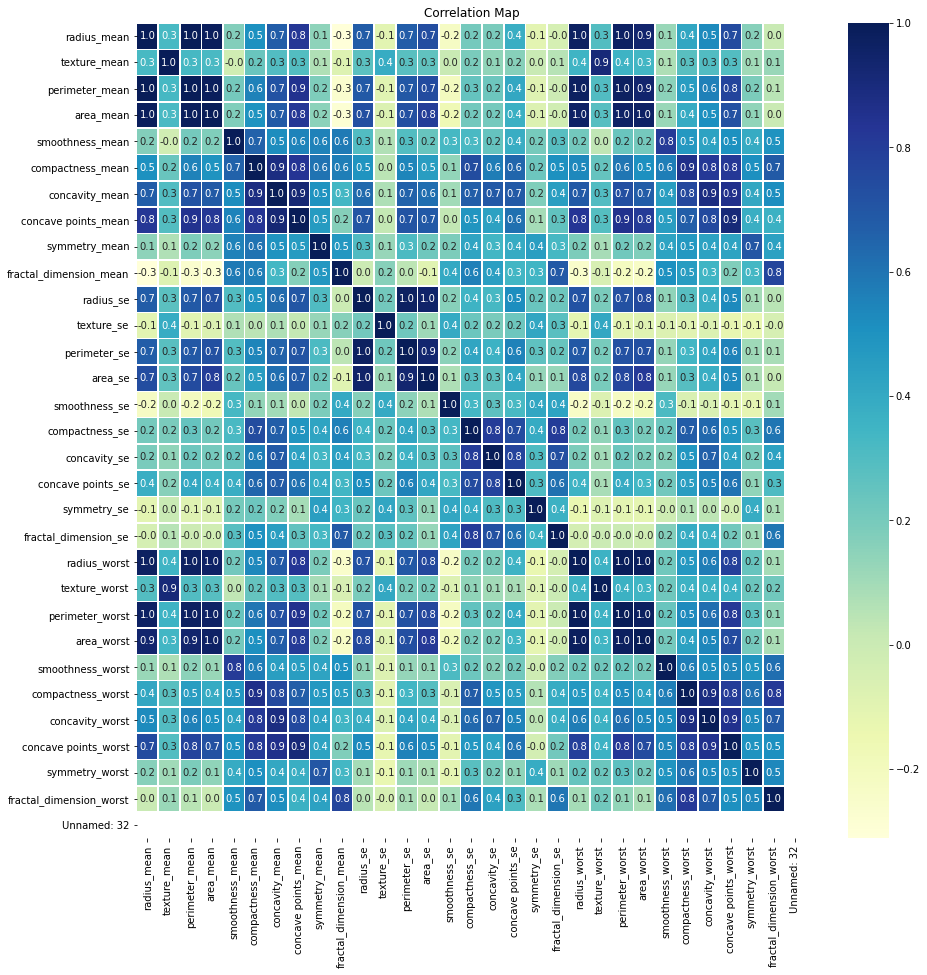

In [140]:
f,ax=plt.subplots(figsize = (15,15))
sns.heatmap(od.iloc[:,1:].corr(),annot= True,linewidths=0.5,fmt = ".1f", ax=ax, cmap="YlGnBu")
plt.title('Correlation Map')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [141]:
#first column is contains ill id 
#last column contain only nan value due to extra delimeter end of line
od = od.drop(od.columns[[0,32]],axis=1)

# # M(malignant) = 0 and B(benign) = 1 enumeration for more accurty results 
od['diagnosis'] = od['diagnosis'].map({'M':0,'B':1})

od = od.dropna()

od.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Feature Selection via CHI Square

In [142]:
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(od.drop(columns="diagnosis"), od.diagnosis, test_size=0.3, random_state=42)

select_feature = SelectKBest(chi2, k=5).fit(x_train, y_train)

print('Score list:', select_feature.scores_)
print('Feature list:', x_train.columns)

zipped = set(zip(x_train.columns,select_feature.scores_))
zipped = sorted(zipped, key=lambda x:x[1], reverse=True)
SELECTED_FEATURES_COL = []
for z in zipped[:5]:
  SELECTED_FEATURES_COL.append(z[0])
print("SELECTED FEATURES :",SELECTED_FEATURES_COL)

Score list: [1.77946492e+02 6.06916433e+01 1.34061092e+03 3.66899557e+04
 1.00015175e-01 3.41839493e+00 1.30547650e+01 7.09766457e+00
 1.95982847e-01 3.42575072e-04 2.45882967e+01 4.07131026e-02
 1.72696840e+02 6.12741067e+03 1.32470372e-03 3.74071521e-01
 6.92896719e-01 2.01587194e-01 1.39557806e-03 2.65927071e-03
 3.25782599e+02 1.16958562e+02 2.40512835e+03 7.50217341e+04
 2.63226314e-01 1.19077581e+01 2.58858117e+01 8.90751003e+00
 1.00635138e+00 1.23087347e-01]
Feature list: Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'c

# CLUSTERING

In [0]:
def translate(mapping):
    def translate_(col):
        return mapping.get(col)
    return udf(translate_, StringType())

def prepareSparkDataFrame():
  path = rootPath+'data/data.csv'
  df = sqlContext.read.csv(path, header=True)
  df = df.drop(*["_c32"])

  df = df.select("*").withColumn("id", monotonically_increasing_id())

  mapping = {"M":0, "B":1}
  df=df.withColumn("diagnosis", translate(mapping)("diagnosis"))

  for col in df.columns[1:]:
        df = df.withColumn(col,df[col].cast('float'))

  df = df.na.drop()

  return df


def clusterKmeans(df,FEATURES_COL):
  # Determine KMEANS Model's Centers
  vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
  df_kmeans = vecAssembler.transform(df).select('id', 'features')
  
  return df_kmeans

def df2pddf(df_kmeans,df):
  transformed = model.transform(df_kmeans).select('id', 'prediction')
  rows = transformed.collect()

  _df_pred = sqlContext.createDataFrame(rows)

  _pddf_df = df.toPandas().set_index("id")
  _pddf_pred = _df_pred.toPandas().set_index("id")

  return _pddf_df, _pddf_pred

def visualize_Kmeans(df_kmeans,pddf_df,pddf_pred,left_title,right_title):

  X = pddf_df.drop('diagnosis', axis=1).values
  X = StandardScaler().fit_transform(X)
  # Scatter plots  https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.scatter.html
  f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,10), sharey=True)
  ax1.scatter(X[:,0], X[:,1], c=pddf_df["diagnosis"], cmap="jet",edgecolor="none", alpha=0.35)
  ax1.set_title(left_title)
  ax2.scatter(X[:,0], X[:,1], c=pddf_pred["prediction"], cmap="jet", edgecolor="none", alpha=0.35)
  ax2.set_title(right_title)
  
  return f

def results_Kmeans(pddf_df,pddf_pred,explanation):
  precision, recall, F1, noe = precision_recall_fscore_support(pddf_df[["diagnosis"]], pddf_pred[["prediction"]], average='macro')
  cf_matrix = confusion_matrix(pddf_df[["diagnosis"]], pddf_pred[["prediction"]])
  sns.heatmap(cf_matrix, annot=True)
  print(explanation)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", F1)

def normalizeDataSet(df):
  columns_to_scale = df.columns[2:]
  assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
  scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
  pipeline = Pipeline(stages=assemblers + scalers)
  scalerModel = pipeline.fit(df)
  scaledData = scalerModel.transform(df)
  return scaledData

def denseVector2float(df,FEATURES_COL):
  firstelement=udf(lambda v:float(v[0]),FloatType())
  for col in FEATURES_COL:
    df = df.withColumn(col,firstelement(col))
    df = df.withColumn(col,df[col].cast('float'))
  return df


## ORIGINAL DATASET

In [225]:
#READ, APPLY PREPROCESSING
df = prepareSparkDataFrame()
FEATURES_COL = df.columns[1:]
df.show()

+---+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
| id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+---+---------+-----------+------------+--------------+---

In [226]:
df_kmeans = clusterKmeans(df,FEATURES_COL)
df_kmeans.show()

+---+--------------------+
| id|            features|
+---+--------------------+
|  0|[0.0,17.989999771...|
|  1|[0.0,20.569999694...|
|  2|[0.0,19.690000534...|
|  3|[0.0,11.420000076...|
|  4|[0.0,20.290000915...|
|  5|[0.0,12.449999809...|
|  6|[0.0,18.25,19.979...|
|  7|[0.0,13.710000038...|
|  8|[0.0,13.0,21.8199...|
|  9|[0.0,12.460000038...|
| 10|[0.0,16.020000457...|
| 11|[0.0,15.779999732...|
| 12|[0.0,19.170000076...|
| 13|[0.0,15.850000381...|
| 14|[0.0,13.729999542...|
| 15|[0.0,14.539999961...|
| 16|[0.0,14.680000305...|
| 17|[0.0,16.129999160...|
| 18|[0.0,19.809999465...|
| 19|[1.0,13.539999961...|
+---+--------------------+
only showing top 20 rows



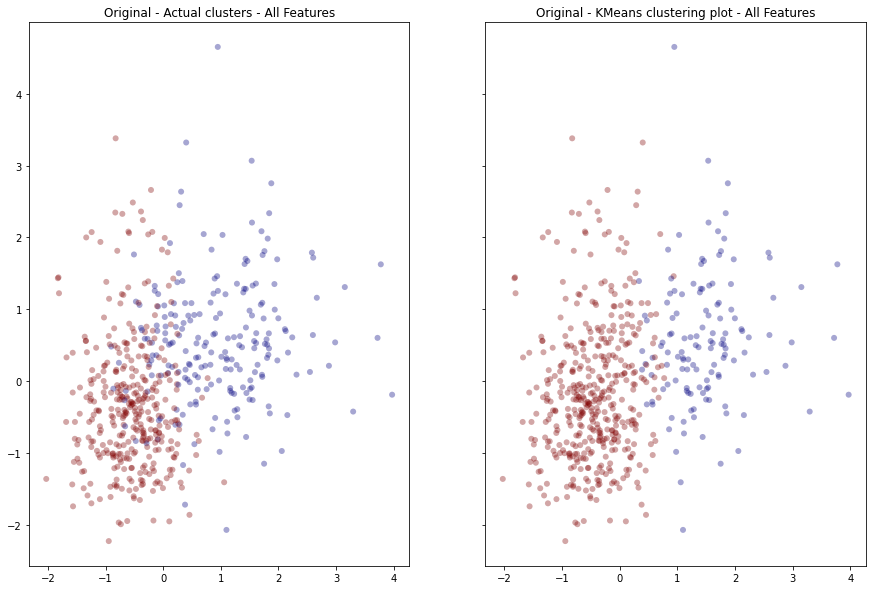

In [227]:
# Visualization KMEANS on Original Dataset
pddf_df, pddf_pred = df2pddf(df_kmeans,df)
f = visualize_Kmeans(df_kmeans,pddf_df, pddf_pred, "Original - Actual clusters - All Features","Original - KMeans clustering plot - All Features")

ORIGINAL DATASET - ALL FEATURES
Precision: 0.9025759001707971
Recall: 0.805203213360816
F1 Score: 0.82680748849405


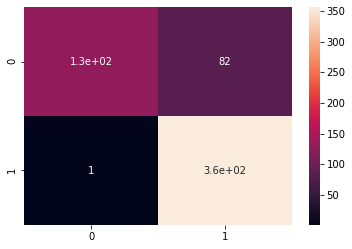

In [228]:
results_Kmeans(pddf_df,pddf_pred,"ORIGINAL DATASET - ALL FEATURES")

## NORMALIZED DATASET

In [242]:
norm_df = prepareSparkDataFrame()
norm_df = normalizeDataSet(norm_df)
#len(norm_df.columns)
norm_df = norm_df.drop(*norm_df.columns[2:62])
norm_FEATURES_COL = norm_df.columns[1:]
norm_df = denseVector2float(norm_df,norm_FEATURES_COL[1:])
norm_df.show()

+---+---------+--------------------+--------------------+---------------------+--------------------+----------------------+-----------------------+---------------------+--------------------------+--------------------+-----------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+------------------------+--------------------+---------------------------+--------------------+--------------------+----------------------+--------------------+-----------------------+------------------------+----------------------+---------------------------+---------------------+------------------------------+
| id|diagnosis|  radius_mean_scaled| texture_mean_scaled|perimeter_mean_scaled|    area_mean_scaled|smoothness_mean_scaled|compactness_mean_scaled|concavity_mean_scaled|concave points_mean_scaled|symmetry_mean_scaled|fractal_dimension_mean_scaled|    radius_se_scaled|   texture_se_scaled| p

In [244]:
norm_df_kmeans = clusterKmeans(norm_df,norm_FEATURES_COL)
norm_df_kmeans.show()
norm_df.summary

+---+--------------------+
| id|            features|
+---+--------------------+
|  0|[0.0,0.5210373997...|
|  1|[0.0,0.6431444883...|
|  2|[0.0,0.6014955639...|
|  3|[0.0,0.2100903987...|
|  4|[0.0,0.6298925876...|
|  5|[0.0,0.2588385343...|
|  6|[0.0,0.5333427786...|
|  7|[0.0,0.3184722363...|
|  8|[0.0,0.2848691344...|
|  9|[0.0,0.2593118548...|
| 10|[0.0,0.4278006553...|
| 11|[0.0,0.4164418280...|
| 12|[0.0,0.5768848657...|
| 13|[0.0,0.4197548329...|
| 14|[0.0,0.3194187879...|
| 15|[0.0,0.3577547371...|
| 16|[0.0,0.3643807172...|
| 17|[0.0,0.4330067038...|
| 18|[0.0,0.6071749329...|
| 19|[1.0,0.3104264140...|
+---+--------------------+
only showing top 20 rows



<bound method DataFrame.summary of DataFrame[id: bigint, diagnosis: float, radius_mean_scaled: float, texture_mean_scaled: float, perimeter_mean_scaled: float, area_mean_scaled: float, smoothness_mean_scaled: float, compactness_mean_scaled: float, concavity_mean_scaled: float, concave points_mean_scaled: float, symmetry_mean_scaled: float, fractal_dimension_mean_scaled: float, radius_se_scaled: float, texture_se_scaled: float, perimeter_se_scaled: float, area_se_scaled: float, smoothness_se_scaled: float, compactness_se_scaled: float, concavity_se_scaled: float, concave points_se_scaled: float, symmetry_se_scaled: float, fractal_dimension_se_scaled: float, radius_worst_scaled: float, texture_worst_scaled: float, perimeter_worst_scaled: float, area_worst_scaled: float, smoothness_worst_scaled: float, compactness_worst_scaled: float, concavity_worst_scaled: float, concave points_worst_scaled: float, symmetry_worst_scaled: float, fractal_dimension_worst_scaled: float]>

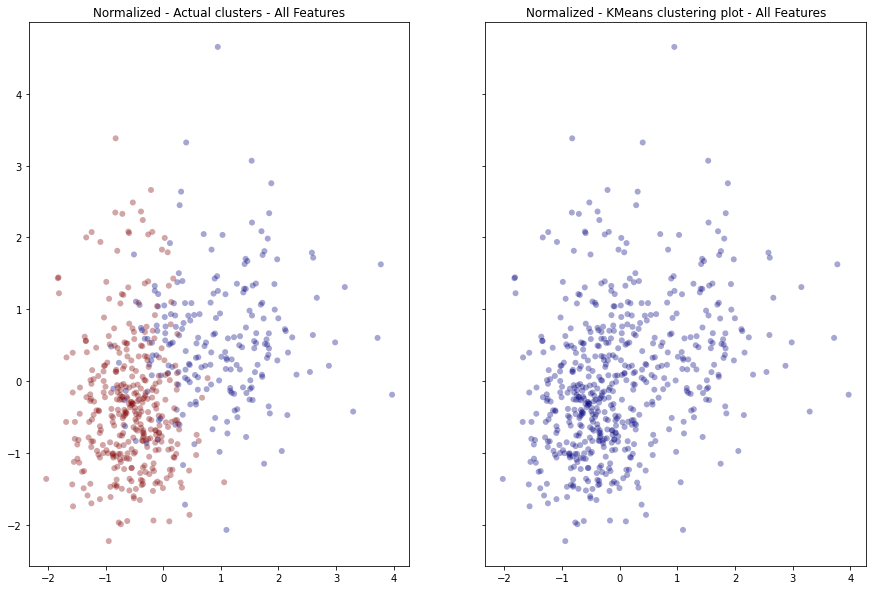

In [248]:
# Visualization KMEANS on Original Dataset
norm_pddf_df, norm_pddf_pred = df2pddf(norm_df_kmeans,norm_df)
norm_f = visualize_Kmeans(norm_df_kmeans, norm_pddf_df, norm_pddf_pred, "Normalized - Actual clusters - All Features","Normalized - KMeans clustering plot - All Features")

In [249]:
norm_pddf_pred

,prediction
id,
0,1
1,1
2,1
3,1
4,1
...,...
564,1
565,1
566,1


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NORMALIZED DATASET - ALL FEATURES
Precision: 0.31370826010544817
Recall: 0.5
F1 Score: 0.3855291576673866


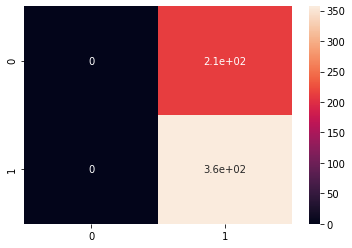

In [246]:
results_Kmeans(norm_pddf_df,norm_pddf_pred,"NORMALIZED DATASET - ALL FEATURES")